# Deep Q-Network (DQN) on LunarLander-v3

### Import the Necessary Packages

In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"

  Using cached swig-4.4.0-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.4.0-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.9 MB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2398998 sha256=d8b9502f3e574813cbaa146744f81661e4f59ec9891d78a49f77afcadadabd53
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [ ]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display
import glob


### Instantiate the Environment and Agent

Initialize the environment.

In [14]:
import gymnasium as gym

env = gym.make("LunarLander-v3")
state, info = env.reset(seed=0)
env.action_space.seed(0)
print("State shape:", len(state))
print("Action space:", env.action_space)


State shape: 8
Action space: Discrete(4)


### Define Neural Network Architecture.

Since `LunarLander-v2` environment is sort of simple envs, we don't need complicated architecture. We just need non-linear function approximator that maps from state to action.

In [15]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

### Define some hyperparameter

In [16]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define Agent

In [18]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Define Replay Buffer

In [19]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Training Process

In [20]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning for LunarLander-v3 using Gymnasium.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in range(1, n_episodes+1):
        state, info = env.reset()
        score = 0
        for t in range(max_t):
            # select action using current policy
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()


Episode 100	Average Score: -155.16
Episode 200	Average Score: -91.29
Episode 300	Average Score: -35.83
Episode 400	Average Score: -26.55
Episode 500	Average Score: 39.35
Episode 600	Average Score: 133.96
Episode 695	Average Score: 200.73
Environment solved in 595 episodes!	Average Score: 200.73


### Plot the learning progress

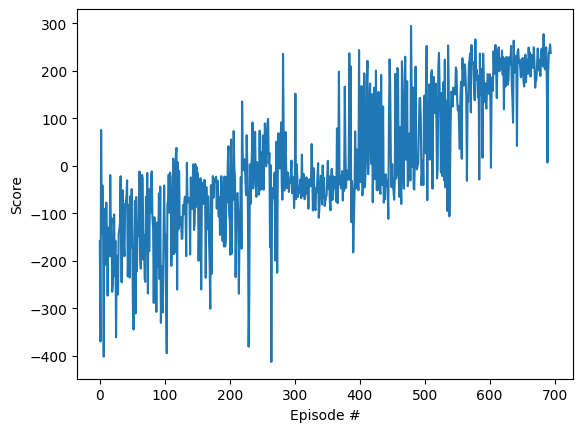

In [21]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Animate it with Video

In [22]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        # take the first video file generated
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(agent, env_name):
    # Create an environment that returns RGB frames and records video
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_folder="video", name_prefix=env_name)
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth', map_location=device))
    state, info = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
    env.close()


In [23]:
agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v3')

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


In [24]:
show_video('LunarLander-v3')

---
## Summary: DQN on LunarLander-v3

This notebook implements a Deep Q-Network (DQN) agent to solve the **LunarLander-v3** environment from OpenAI Gym.

**Architecture & Hyperparameters**
- Q-network: fully-connected MLP with two hidden layers of size 64, ReLU activations, and a linear output layer over 4 discrete actions.
- Replay buffer: capacity `1e5`, mini-batch size `64` sampled uniformly.
- Optimization: Adam optimizer with learning rate `5e-4`, discount factor `γ = 0.99`.
- Target network: separate Q-network updated via soft updates with `τ = 1e-3` after every learning step.
- Exploration: ε-greedy policy with `ε` decaying from `1.0` to `0.01` using multiplicative decay factor `0.995` per episode.

**Training Loop**
- Each episode runs up to `max_t` steps; at each step the agent selects an action using ε-greedy, observes reward and next state, and stores the transition in the replay buffer.
- Every `UPDATE_EVERY = 4` steps, if enough samples are available, the agent samples a mini-batch and performs a learning update by minimizing the MSE between target Q-values and predicted Q-values.
- The environment is considered *solved* when the moving average reward over the last 100 episodes exceeds **200**, at which point the local Q-network weights are saved to `checkpoint.pth`.

**Visualization**
- A learning curve plots episode scores over time to show improvement.
- Helper functions record a video using the saved checkpoint and render the trained agent landing the lunar module.

This completes the DQN implementation and provides all components needed to train, evaluate, and visualize a LunarLander-v3 agent.
